# Building a Llama 2 chatbot with Retrieval Augmented Generation (RAG)

This notebook shows a complete example of how to build a Llama 2 chatbot hosted on your browser that can answer questions based on your own data. We'll cover:
* The deployment process of Llama 2 7B with the [Text-generation-inference](https://github.com/huggingface/text-generation-inference) framework as an API server
* A chatbot example built with [Gradio](https://github.com/gradio-app/gradio) and wired to the server
* Adding RAG capability with Llama 2 specific knowledge based on our Getting Started [guide](https://ai.meta.com/llama/get-started/)

## RAG Architecture

LLMs have unprecedented capabilities in NLU (Natural Language Understanding) & NLG (Natural Language Generation), but they have a knowledge cutoff date, and are only trained on publicly available data before that date.

RAG, invented by [Meta](https://ai.meta.com/blog/retrieval-augmented-generation-streamlining-the-creation-of-intelligent-natural-language-processing-models/) in 2020, is one of the most popular methods to augment LLMs. RAG allows enterprises to keep sensitive data on-prem and get more relevant answers from generic models without fine-tuning models for specific roles.

RAG is a method that:
* Retrieves data from outside a foundation model
* Augments your questions or prompts to LLMs by adding the retrieved relevant data as context
* Allows LLMs to answer questions about your own data, or data not publicly available when LLMs were trained
* Greatly reduces the hallucination in  model's response generation

The following diagram shows the general RAG components and process:

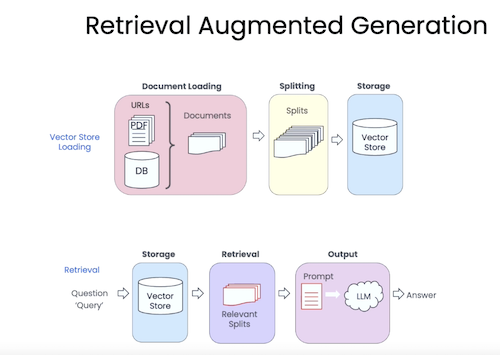

## How to Develop a RAG Powered Llama 2 Chatbot

The easiest way to develop RAG-powered Llama 2 chatbots is to use frameworks such as [**LangChain**](https://www.langchain.com/) and [**LlamaIndex**](https://www.llamaindex.ai/), two leading open-source frameworks for building LLM apps. Both offer convenient APIs for implementing RAG with Llama 2 including:

* Load and split documents
* Embed and store document splits
* Retrieve the relevant context based on the user query
* Call Llama 2 with query and context to generate the answer

LangChain is a more general purpose and flexible framework for developing LLM apps with RAG capabilities, while LlamaIndex as a data framework focuses on connecting custom data sources to LLMs. The integration of the two may provide the best performant and effective solution to building real world RAG apps.  
In our example, for simplicifty, we will use LangChain alone with locally stored PDF data.

### Install Dependencies

For this demo, we will be using the Gradio for chatbot UI, Text-generation-inference framework for model serving.  
For vector storage and similarity search, we will be using [FAISS](https://github.com/facebookresearch/faiss).  
In this example, we will be running everything in a AWS EC2 instance (i.e. [g5.2xlarge]( https://aws.amazon.com/ec2/instance-types/g5/)). g5.2xlarge features one A10G GPU. We recommend running this notebook with at least one GPU equivalent to A10G with at least 16GB video memory.  
There are certain techniques to downsize the Llama 2 7B model, so it can fit into smaller GPUs. But it is out of scope here.

First, let's install all dependencies with PIP. We also recommend you start a dedicated Conda environment for better package management

In [ ]:
!pip install -r requirements.txt

### Data Processing

First run all the imports and define the path of the data and vector storage after processing.  
For the data, we will be using a raw pdf crawled from Llama 2 Getting Started guide on [Meta AI website](https://ai.meta.com/llama/).

In [5]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.document_loaders import PyPDFDirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter 

DATA_PATH = 'data' #Your root data folder path
DB_FAISS_PATH = 'vectorstore/db_faiss'

Then we use the `PyPDFDirectoryLoader` to load the entire directory. You can also use `PyPDFLoader` for loading one single file.

In [6]:
loader = PyPDFDirectoryLoader(DATA_PATH)
documents = loader.load()

Check the length and content of the doc to ensure we have loaded the right document with number of pages as 37.

In [ ]:
print(len(documents), documents[0].page_content[0:100])

Split the loaded documents into smaller chunks.  
[`RecursiveCharacterTextSplitter`](https://api.python.langchain.com/en/latest/text_splitter/langchain.text_splitter.RecursiveCharacterTextSplitter.html) is one common splitter that splits long pieces of text into smaller, semantically meaningful chunks.  
Other splitters include:
* SpacyTextSplitter
* NLTKTextSplitter
* SentenceTransformersTokenTextSplitter
* CharacterTextSplitter


In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=10)
splits = text_splitter.split_documents(documents)
print(len(splits), splits[0])

Note that we have set `chunk_size` to 500 and `chunk_overlap` to 10. In the spliting, these two parameters can directly affects the quality of the LLM's answers.  
Here is a good [guide](https://dev.to/peterabel/what-chunk-size-and-chunk-overlap-should-you-use-4338) on how you should carefully set these two parameters.

Next we will need to choose an embedding model for our splited documents.  
**Embeddings are numerial representations of text**. The default embedding model in HuggingFace Embeddings is `sentence-transformers/all-mpnet-base-v2` with 768 dimension. Below we use a smaller model `all-MiniLM-L6-v2` with dimension 384 so indexing runs faster.

In [50]:
embeddings = HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2',
                                       model_kwargs={'device': 'cpu'})

Lastly, with splits and choice of the embedding model ready, we want to index them and store all the split chunks as embeddings into the vector storage.  

Vector stores are databases storing embeddings. There're at least 60 [vector stores](https://python.langchain.com/docs/integrations/vectorstores) supported by LangChain, and two of the most popular open source ones are:
* [Chroma](https://www.trychroma.com/): a light-weight and in memory so it's easy to get started with and use for **local development**.
* [FAISS](https://python.langchain.com/docs/integrations/vectorstores/faiss) (Facebook AI Similarity Search): a vector store that supports search in vectors that may not fit in RAM and is appropriate for **production use**.  

Since we are running on a EC2 instance with abundant CPU resources and RAM, we will use FAISS in this example. Note that FAISS can also run on GPUs, where some of the most useful algorithms are implemented there. In that case, install `faiss-gpu` package with PIP instead.

In [51]:
db = FAISS.from_documents(splits, embeddings)
db.save_local(DB_FAISS_PATH)

Once you saved database into local path. You can find them as `index.faiss` and `index.pkl`. In the chatbot example, you can then load this database from local and plug it into our retrival process.

### Model Serving

In this example, we will be deploying a Llama 2 7B chat HuggingFace model with the Text-generation-inference framework on-permises.  
This would allow us to directly wire the API server with our chatbot.  
There are alternative solutions to deploy Llama 2 models on-permises as your local API server.  
You can find our complete guide [here](https://github.com/facebookresearch/llama-recipes/blob/main/demo_apps/llama-on-prem.md).

In a **separate terminal**, run commands below to launch an API server with TGI. This will download model artifacts and store them locally, while launching at the desire port on your localhost. In our case, this is port 8080

In [ ]:
model = meta-llama/Llama-2-7b-chat-hf
volume = $PWD/data
token = #Your own HF tokens
docker run --gpus all --shm-size 1g -e HUGGING_FACE_HUB_TOKEN=$token -p 8080:80 -v $volume:/data ghcr.io/huggingface/text-generation-inference:1.1.0 --model-id $model

Once we have the API server up and running, we can run a simple `curl` command to validate our model is working as expected.

In [ ]:
!curl localhost:8080/generate -X POST -H 'Content-Type: application/json' -d '{"inputs": "What is good about Beijing?", "parameters": { "max_new_tokens":64}}' #Replace the locahost with the IP visible to the machine running the notebook     

### Building the Chatbot UI

Now we are ready to build the chatbot UI to wire up RAG data and API server. In our example we will be using Gradio to build the Chatbot UI.  
Gradio is an open-source Python library that is used to build machine learning and data science demos and web applications. It had been widely used by the community and HuggingFace also used Gradio to build their Chatbots. Other alternatives are: 
* [Streamlit](https://streamlit.io/)
* [Dash](https://plotly.com/dash/)
* [Flask](https://flask.palletsprojects.com/en/3.0.x/)

Again, we start by adding all the imports, paths, constants and set LangChain in debug mode, so it shows clear actions within the chain process.

In [9]:
import langchain
from queue import Queue
from typing import Any
from langchain.llms.huggingface_text_gen_inference import HuggingFaceTextGenInference
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.schema import LLMResult
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains import RetrievalQA
from langchain.prompts.prompt import PromptTemplate
from anyio.from_thread import start_blocking_portal #For model callback streaming

langchain.debug=True 

#vector db path
DB_FAISS_PATH = 'vectorstore/db_faiss'

#Llama2 TGI models host port
LLAMA2_7B_HOSTPORT = "http://localhost:8080/" #Replace the locahost with the IP visible to the machine running the notebook
LLAMA2_13B_HOSTPORT = "http://localhost:8080/" #Add your own host ports for model switching. You can host another TGI model on same instance on a different port.


model_dict = {
    "7b-chat" : LLAMA2_7B_HOSTPORT,
    "13b-chat" : LLAMA2_13B_HOSTPORT,
}

system_message = {"role": "system", "content": "You are a helpful assistant."}

Then we load the FAISS vector store

In [ ]:
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2",
                                       model_kwargs={'device': 'cpu'})
db = FAISS.load_local(DB_FAISS_PATH, embeddings)

Now we create a TGI llm instance and wire to the API serving port on localhost

In [11]:
llm = HuggingFaceTextGenInference(
    inference_server_url=LLAMA2_7B_HOSTPORT,
    max_new_tokens=512,
    top_k=10,
    top_p=0.9,
    typical_p=0.95,
    temperature=0.6,
    repetition_penalty=1,
    do_sample=True,
    streaming=True
)

Next, we define the retriever and template for our RetrivalQA chain. For each call of the RetrievalQA, LangChain performs a semantic similarity search of the query in the vector database, then passes the search results as the context to Llama to answer the query about the data stored in the verctor database.  
Whereas for the template, this defines the format of the question along with context that we will be sent into Llama for generation. In general, Llama 2 has special prompt format to handle special tokens. In some cases, the serving framework might already have taken care of it. Otherwise, you will need to write customized template to properly handle that.


In [12]:
template = """
[INST]Use the following pieces of context to answer the question. If no context provided, answer like a AI assistant.
{context}
Question: {question} [/INST]
"""

retriever = db.as_retriever(
        search_kwargs={"k": 6}
    )

Lastly, we can define the retrieval chain for QA

In [13]:
qa_chain = RetrievalQA.from_chain_type(
    llm=llm, 
    retriever=retriever,     
    chain_type_kwargs={
        "prompt": PromptTemplate(
            template=template,
            input_variables=["context", "question"],
        ),
    }
)

Now we should have a working chain for QA. Let's test it out before wire it up with UI blocks.

In [ ]:
result = qa_chain({"query": "Why choose Llama?"})
print(result)

After confirming the validity, we can start building the UI. Before we define the gradio [blocks](https://www.gradio.app/docs/blocks), let's first define the callback streams that we will use later for the streaming feature.  
This callback handler will put streaming LLM responses to a queue for gradio UI to render on the fly. 

In [14]:
job_done = object()

class MyStream(StreamingStdOutCallbackHandler):
    def __init__(self, q) -> None:
        self.q = q

    def on_llm_new_token(self, token: str, **kwargs: Any) -> None:
        self.q.put(token)

    def on_llm_end(self, response: LLMResult, **kwargs: Any) -> None:
        self.q.put(job_done)

Now we can define the gradio UI blocks.  
Since we will need to define the UI and handlers in the same place, this will be a large chunk of code. We will add comments in the code for explanation.

In [15]:
import gradio as gr

with gr.Blocks() as demo:
    #Configure UI layout
    chatbot = gr.Chatbot(height = 600)
    with gr.Row():
        with gr.Column(scale=1):
            with gr.Row():
                #model selection
                model_selector = gr.Dropdown(
                    list(model_dict.keys()), 
                    value="7b-chat", 
                    label="Model", 
                    info="Select the model", 
                    interactive = True, 
                    scale=1
                )
                max_new_tokens_selector = gr.Number(
                    value=512, 
                    precision=0, 
                    label="Max new tokens", 
                    info="Adjust max_new_tokens",
                    interactive = True, 
                    minimum=1, 
                    maximum=1024, 
                    scale=1
                )
            with gr.Row():
                #hyperparameter selection
                temperature_selector = gr.Slider(
                    value=0.6, 
                    label="Temperature", 
                    info="Range 0-2. Controls the creativity of the generated text.",
                    interactive = True, 
                    minimum=0.01, 
                    maximum=2, 
                    step=0.01, 
                    scale=1
                )
                top_p_selector = gr.Slider(
                    value=0.9, 
                    label="Top_p", 
                    info="Range 0-1. Nucleus sampling.",
                    interactive = True, 
                    minimum=0.01, 
                    maximum=0.99, 
                    step=0.01, 
                    scale=1
                )
        with gr.Column(scale=2):
            #user input prompt text field
            user_prompt_message = gr.Textbox(placeholder="Please add user prompt here", label="User prompt")
            with gr.Row():
                clear = gr.Button("Clear Conversation", scale=2)
                submitBtn = gr.Button("Submit", scale=8)


    state = gr.State([])

    #handle user message
    def user(user_prompt_message, history):
        if user_prompt_message != "":
            return history + [[user_prompt_message, None]]
        else:
            return history + [["Invalid prompts - user prompt cannot be empty", None]]

    #chatbot logic for configuration, sending the prompts, rendering the streamed back genereations etc
    def bot(model_selector, temperature_selector, top_p_selector, max_new_tokens_selector, user_prompt_message, history, messages_history):
        dialog = []
        bot_message = ""
        history[-1][1] = ""
           
        dialog = [
            {"role": "user", "content": user_prompt_message},
        ]
        messages_history += dialog
        
        #Queue for streamed character rendering
        q = Queue()

        #Update new llama hyperparameters
        llm.inference_server_url = model_selector
        llm.temperature = temperature_selector
        llm.top_p = top_p_selector
        llm.max_new_tokens = max_new_tokens_selector

        #Async task for streamed chain results wired to callbacks we previously defined, so we don't block the UI
        async def task(prompt):
            ret = await qa_chain.run(prompt, callbacks=[MyStream(q)])
            return ret

        with start_blocking_portal() as portal:
            portal.start_task_soon(task, user_prompt_message)
            while True:
                next_token = q.get(True)
                if next_token is job_done:
                    messages_history += [{"role": "assistant", "content": bot_message}]
                    return history, messages_history
                bot_message += next_token
                history[-1][1] += next_token
                yield history, messages_history

    #init the chat history with default system message    
    def init_history(messages_history):
        messages_history = []
        messages_history += [system_message]
        return messages_history

    #clean up the user input text field
    def input_cleanup():
        return ""

    #when the user clicks Enter and the user message is submitted
    user_prompt_message.submit(
        user, 
        [user_prompt_message, chatbot], 
        [chatbot], 
        queue=False
    ).then(
        bot, 
        [model_selector, temperature_selector, top_p_selector, max_new_tokens_selector, user_prompt_message, chatbot, state], 
        [chatbot, state]
    ).then(input_cleanup, 
        [], 
        [user_prompt_message], 
        queue=False
    )

    #when the user clicks the submit button
    submitBtn.click(
        user, 
        [user_prompt_message, chatbot], 
        [chatbot], 
        queue=False
    ).then(
        bot, 
        [model_selector, temperature_selector, top_p_selector, max_new_tokens_selector, user_prompt_message, chatbot, state], 
        [chatbot, state]
    ).then(
        input_cleanup, 
        [], 
        [user_prompt_message], 
        queue=False
    )
    
    #when the user clicks the clear button
    clear.click(lambda: None, None, chatbot, queue=False).success(init_history, [state], [state])

Lastly, we can launch this demo on our localhost with the command below. 

In [16]:
demo.queue().launch(server_name="0.0.0.0")

Running on local URL:  http://0.0.0.0:7860

To create a public link, set `share=True` in `launch()`.


Gradio will default the launch port to 7860. You can select which port it should launch on as needed.  
Once launched, in the notebook or a browser with URL http://0.0.0.0:7860, you should see the UI.  
Things to try in the chatbot demo:  
* Asking specific questions related to the Llama 2 Getting Started Guide
* Adjust parameters such as max new token generated
* Switching to another Llama model with another container launched in a separate terminal

Once finished testing, make sure you close the demo by running the command below to release the port.

In [ ]:
demo.close()